### Extracting the menu

In [1]:
import re
import glob
import csv
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
#selenium imports
#install geckodriver first and make sure you have selenium installed and firefox is a version > 53.0
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
class Restaurant:
    """
    Represents a restaurant with all the menu.
    Used for scraping before covnerting everything to csv.
    """
    def __init__(self, url, from_html=True):
        self.url = url
        self.from_html = from_html
        
    def scrape(self):
        if self.from_html:
            self.html = urllib.request.urlopen(url).read()
        else:
            self.html = open(url, "r").read()
        self.soup = BeautifulSoup(self.html, "lxml")
        self.scrape_menu()
        self.scrape_info()
        self.clean_scrape()
        if self.from_html:
            with open("restaurants_pages/{}.html".format(self.restaurant_name), "w") as htmlfile:
                htmlfile.write(self.html.decode())

        # Cleanup to avoid using too much memo 
        del self.html
        del self.soup
        
        
    def scrape_menu(self):
        self.menu_items, self.menu_prices = [], []
        both = self.scrape_all_class("cardCategory-item")
        
        for line in both:
            title = line.find(class_="cardCategory-itemTitle")
            price = line.find(class_="cardCategory-itemPrice")
            if title and price:
                self.menu_items.append(title)
                self.menu_prices.append(price)

    def scrape_info(self):
        self.avg_price = self.scrape_all_class("pull-left restaurantSummary-price", True)
        self.tags = self.scrape_all_class("restaurantTag")
        self.location = self.scrape_all_class("restaurantSummary-address", True)
        self.restaurant_name = self.scrape_all_class("restaurantSummary-name", True)
        self.glob_rating = self.scrape_all_class("rating-ratingValue", True)
        
    def scrape_all_class(self, name, first=False):
        if first:
            return self.soup.find(class_=name)
        else:
            return list(self.soup.find_all(class_=name))
        
    def clean_scrape(self):
        def get_clean_text(string):
            return string.text.strip()
        
        def prices_as_numbers(price):
            intermediary = replace_dict(price, {"€": "", "\xa0": "", ",": ".", " ": "",
                                              "\\xac": "", "\\n": ""})
            try:
                return(float(intermediary))
            except:
                return -1
            
        
        def replace_dict(text, changes):
            for old, new in changes.items():
                text = text.replace(old, new)
            return text
        
        self.menu_items = map(get_clean_text, self.menu_items)
        self.tags = map(get_clean_text, self.tags)
        self.location = get_clean_text(self.location)
        self.restaurant_name = get_clean_text(self.restaurant_name)
        self.menu_prices = map(get_clean_text, self.menu_prices)
        self.menu_prices = map(prices_as_numbers, self.menu_prices)
        self.avg_price = prices_as_numbers(get_clean_text(self.avg_price)[-8:])
        self.glob_rating = prices_as_numbers(get_clean_text(self.glob_rating))
    
    def iter_menu(self):
        for item, price in zip(self.menu_items, self.menu_prices):
            yield (self.restaurant_name, item, price, self.url, self.glob_rating, self.avg_price,
                   self.location, list(self.tags))

#### Example

In [13]:
url = "https://www.lafourchette.com/restaurant/le-23-clauzel-julie-riviere/6999"
rest = Restaurant(url)
rest.scrape()
rest.restaurant_name

'Le 23 Clauzel - Julie Rivière -'

### Extracting the list of restaurants

In [4]:
#introducting the functions for wait times
def wait(dr, x, t,i):
    element = WebDriverWait(dr, t).until(EC.text_to_be_present_in_element((By.XPATH, x),i))
    return element

In [5]:
######## check code to make sure the driver works, don't run it each time##########
#dr = webdriver.PhantomJS(service_args=['--ignore-ssl-errors=true'])
dr = webdriver.Firefox()
dr.get("https://www.lafourchette.com/restaurant+paris#sort=QUALITY_DESC&page=105")
wait(dr,"//li[@class='active']",10,"105")

True

In [11]:
####### check code to see if it works with beautifulsoup::::: NOT parsing all the strings but still does a good work###########
soup = BeautifulSoup(dr.page_source, 'lxml')
base_url = "https://www.lafourchette.com"
pattern = re.compile("/restaurant/[a-z-]+/[0-9]+$")
restaurants = []
restaurants.extend(base_url + rest["href"] for rest in soup.find_all(href=pattern))

NameError: name 'dr' is not defined

In [7]:
with open("temp_page_source.html","w") as f:
    f.write(dr.page_source)

In [29]:
###### FIXED the find_restaurants #########

def find_restaurants():
    
    base_url_search = "https://www.lafourchette.com"
    base_url = "https://www.lafourchette.com/"
    search_url = base_url + "restaurant+paris#sort=QUALITY_DESC&page={}"
    pattern = re.compile("restaurant/[a-z-]+/[0-9]+$")
    restaurants = []
    for i in range(1, 255):
        dr = webdriver.Firefox()
        if i % 10 == 0:
            print("Handled {} pages, have {} restaurant urls".format(i, len(restaurants)))
        search_page = search_url.format(i)
        dr.get(search_page)
        wait(dr,"//li[@class='active']",10,str(i))
        soup = BeautifulSoup(dr.page_source, "lxml")
        temp = []
        temp.extend(base_url_search + rest["href"] for rest in soup.find_all(href=pattern))
        temp = list(set(temp))
        #restaurants.extend(base_url + rest["href"] for rest in soup.find_all(href=pattern))
        restaurants.extend(temp)
        dr.quit()
    
    return restaurants


In [10]:
### Will take a lot of time to complete ~1-2 hrs depending on the internet speed. Couldn't get phantomJS to work 
#### or would  have been faster ####

restaurants = find_restaurants()

len(restaurants)

Handled 10 pages, have 218 restaurant urls
Handled 20 pages, have 458 restaurant urls
Handled 30 pages, have 695 restaurant urls
Handled 40 pages, have 930 restaurant urls
Handled 50 pages, have 1163 restaurant urls
Handled 60 pages, have 1401 restaurant urls
Handled 70 pages, have 1640 restaurant urls
Handled 80 pages, have 1877 restaurant urls
Handled 90 pages, have 2119 restaurant urls
Handled 100 pages, have 2361 restaurant urls
Handled 110 pages, have 2602 restaurant urls
Handled 120 pages, have 2843 restaurant urls
Handled 130 pages, have 3080 restaurant urls
Handled 140 pages, have 3322 restaurant urls
Handled 150 pages, have 3563 restaurant urls
Handled 160 pages, have 3801 restaurant urls
Handled 170 pages, have 4040 restaurant urls
Handled 180 pages, have 4280 restaurant urls
Handled 190 pages, have 4519 restaurant urls
Handled 200 pages, have 4764 restaurant urls
Handled 210 pages, have 5007 restaurant urls
Handled 220 pages, have 5135 restaurant urls
Handled 230 pages, have

5135

### Saving in case we need to reload...

In [3]:
pd.Series(restaurants).to_csv("rest.csv", index=False)

### To go back from saved data

In [3]:
# To rescrape
restaurants = pd.read_csv("rest.csv").restaurants
dl = True

In [7]:
# To do it from downloaded archives:
from glob import glob
restaurants = glob("restaurants_pages/*.html")
dl = False

In [8]:
### We want to make sure we save periodically given all the issues

fails = 0
obj_rests = []
failed = []


with open("items.csv", "w") as csvfile:
    # Use tab because "," or ";" might be used in description
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(["rest_name", "item", "item_price", "rest_url", "rest_global_rating",
                     "rest_avg_price", "rest_location", "rest_tags"])

    
for i, url in enumerate(restaurants):
    if not (i+1) % 50:
        print("Parsed {} restaurants".format(i+1))
        print("Saving menu...")
        
        with open("all_items.csv", "a+") as csvfile:
        # Use tab because "," or ";" might be used in description
            writer = csv.writer(csvfile, delimiter='\t')
            for restaurant_menu in obj_rests[i-50:]:
                try:
                    writer.writerows(restaurant_menu.iter_menu())
                except:
                    fails += 1

    rest = Restaurant(url, from_html=dl)
    try:
        rest.scrape()
        obj_rests.append(rest)
    except:
        failed.append(rest)

Parsed 1750 restaurants
Saving menu...
Parsed 1800 restaurants
Saving menu...
Parsed 1850 restaurants
Saving menu...
Parsed 1900 restaurants
Saving menu...
Parsed 1950 restaurants
Saving menu...
Parsed 2000 restaurants
Saving menu...
Parsed 2050 restaurants
Saving menu...
Parsed 2100 restaurants
Saving menu...
Parsed 2150 restaurants
Saving menu...
Parsed 2200 restaurants
Saving menu...
Parsed 2250 restaurants
Saving menu...
Parsed 2300 restaurants
Saving menu...
Parsed 2350 restaurants
Saving menu...
Parsed 2400 restaurants
Saving menu...
Parsed 2450 restaurants
Saving menu...
Parsed 2500 restaurants
Saving menu...
Parsed 2550 restaurants
Saving menu...
Parsed 2600 restaurants
Saving menu...
Parsed 2650 restaurants
Saving menu...
Parsed 2700 restaurants
Saving menu...
Parsed 2750 restaurants
Saving menu...
Parsed 2800 restaurants
Saving menu...
Parsed 2850 restaurants
Saving menu...
Parsed 2900 restaurants
Saving menu...
Parsed 2950 restaurants
Saving menu...
Parsed 3000 restaurants
S

In [24]:
test.iloc[19].rest_url

'https://www.lafourchette.com/restaurant/le-celadon-hotel-westminster/318887'

In [25]:
test.iloc[19]

rest_name                                 Le Céladon, Hotel Westminster
item                  Les Huîtres de la famille Boutrais en tartare ...
item_price                                                           20
rest_url              https://www.lafourchette.com/restaurant/le-cel...
rest_global_rating                                                  9.2
rest_avg_price                                                       50
rest_location         15 Rue Daunou\n                        75002\n...
rest_tags                                                            []
Name: 19, dtype: object

In [15]:
test = pd.read_csv("all_items.csv", sep="\t")

In [28]:
test.drop_duplicates().shape

(94279, 8)

In [36]:
test.drop_duplicates(['rest_name', 'item', 'item_price', 'rest_global_rating',
       'rest_avg_price', 'rest_location', 'rest_tags']).to_csv("all_items_improved.csv", index=False)

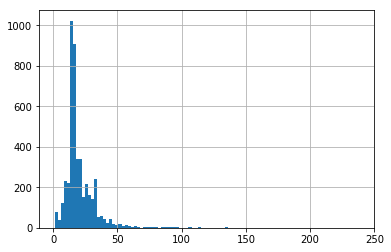

In [27]:
%matplotlib inline
test.rest_name.value_counts().hist(bins=100)

In [43]:
data = pd.read_csv("all_items_improved.csv")
data

,rest_name,item,item_price,rest_url,rest_global_rating,rest_avg_price,rest_location,rest_tags
0,Les Garcons Bouchers,Bruschetta Foie de Volaille sur nid de Roquett...,10.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,33 Avenue Philippe-Auguste\n ...,"['Français', 'Bistrot', 'Entre amis', 'Anniver..."
1,Les Garcons Bouchers,Planche de charcuteries (à partager à 2 ou 3 p...,25.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,33 Avenue Philippe-Auguste\n ...,[]
2,Les Garcons Bouchers,Poêlé de Foie de Volaille sur Nid de Roquette,14.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,33 Avenue Philippe-Auguste\n ...,[]
3,Les Garcons Bouchers,Le Hamburger Rossini 200 gr,26.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,33 Avenue Philippe-Auguste\n ...,[]
4,Les Garcons Bouchers,La côte de Bœuf ~ 500 gr,33.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,33 Avenue Philippe-Auguste\n ...,[]
5,Les Garcons Bouchers,Le Magret de Canard,30.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,33 Avenue Philippe-Auguste\n ...,[]
6,Les Garcons Bouchers,Fondant au Chocolat et sa boule Vanille,8.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,33 Avenue Philippe-Auguste\n ...,[]
7,Les Garcons Bouchers,Melon,8.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,33 Avenue Philippe-Auguste\n ...,[]
8,Les Garcons Bouchers,Sabayon Fraise,9.0,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,33 Avenue Philippe-Auguste\n ...,[]
9,Les Garcons Bouchers,Demi bouteille d'eau minérale,4.5,https://www.lafourchette.com/restaurant/les-ga...,8.6,36.0,33 Avenue Philippe-Auguste\n ...,[]


In [42]:
data.rest_name.nunique()

4603